# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [19]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
neer = read_prices("../../Dymon/Code Data/NEER.csv")

In [5]:
neer.columns = [x[0] for x in neer.columns]

In [6]:
g10_neer = neer[[("JBDN"+x+" Index") for x in [x[3:] for x in G10_FX]]]
g10_neer.columns = G10_FX

In [7]:
g10_neer_cleaned = g10_neer.pipe(fill_date, True).pipe(omit_trailing_na)

# Data integrity

In [8]:
g10_neer.pipe(fill_date).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5665 entries, 2000-01-03 to 2021-09-17
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDAUD  5445 non-null   float64
 1   USDCAD  5445 non-null   float64
 2   USDEUR  5445 non-null   float64
 3   USDGBP  5445 non-null   float64
 4   USDJPY  5445 non-null   float64
 5   USDNZD  5445 non-null   float64
 6   USDSEK  5445 non-null   float64
 7   USDNOK  5445 non-null   float64
 8   USDCHF  5445 non-null   float64
dtypes: float64(9)
memory usage: 442.6 KB


<AxesSubplot:>

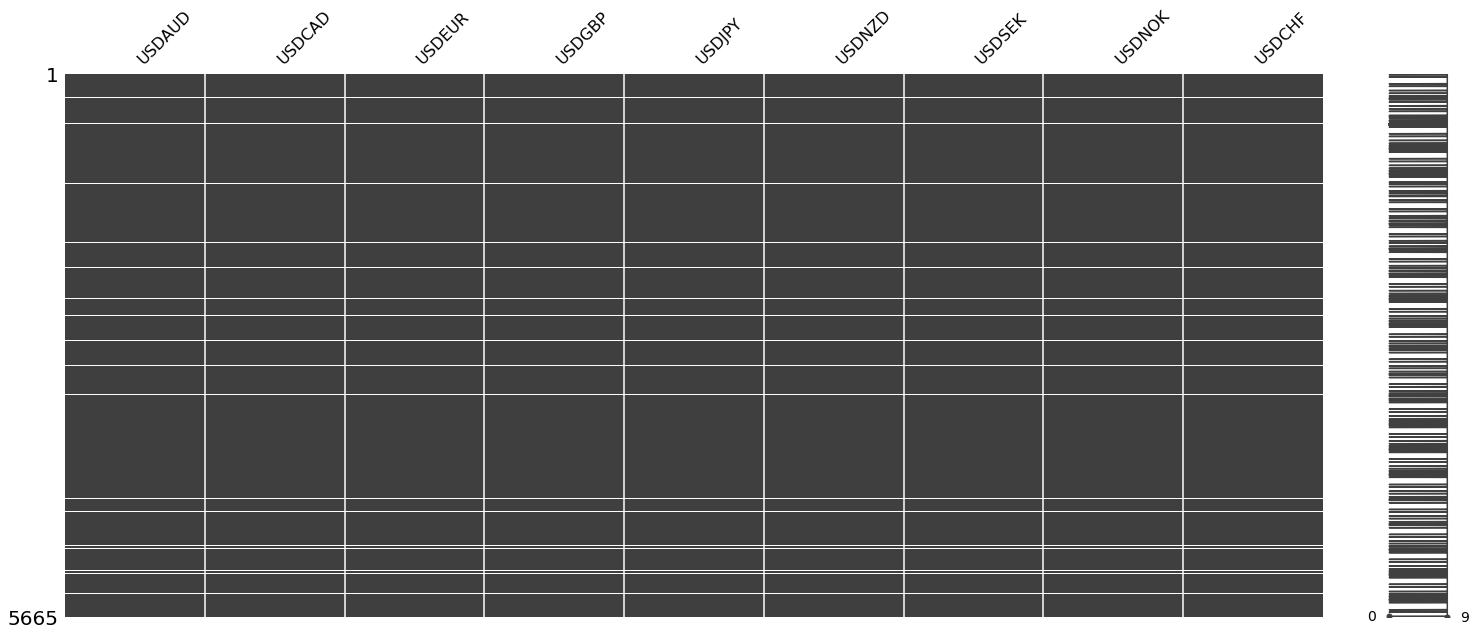

In [9]:
msmx(g10_neer.pipe(fill_date))

# Signal 

In [10]:
def band_filter(series):
  return series.applymap(lambda x: -x if abs(x) > 1.5 else 0)

def hold_until_flip(series):
  ser = pd.DataFrame(series)
  ser.columns = ["ccy"]
  ser["shift"] = ser.shift(1)
  ser["sign_change"] = ser.apply(lambda row: 1 if abs(row["ccy"]) > 1.5 else 0, axis=1)
  ser["sign_change"] = ser.apply(lambda row: 1 if row["sign_change"] == 1 else np.nan if pd.isna(row["ccy"]) else 4 if np.sign(row["ccy"]) != np.sign(row["shift"]) else 0 , axis=1)
  ser["signal"] = ser[["ccy"]].pipe(band_filter)
  ser['sign_forward']=ser['sign_change'].replace(0, np.NaN).ffill()
  ser['sign_shift'] = ser['sign_forward'].diff().replace(0, np.NaN)
  ser["signal"] = ser.apply(lambda row: np.nan if pd.isna(row["sign_shift"]) else row["signal"], axis=1).ffill()
  
  return ser["signal"]

In [11]:
sig = g10_neer_cleaned.ffill().pct_change().pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1

In [12]:
sig = sig.pipe(demean_xs).pipe(top_bottom_xs)
sig[abs(sig) < 0.25] = 0
sig = CAP(sig, 2.5)

# Backtest Daily Rebal

In [13]:
daily_bt = Backtest(signal = sig, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings)
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [14]:
get_summary(daily_bt)

Returns   : 0.039900097792548314
Vol       : 0.11044074613076464
SR        : 0.3612805888263883
Max DD    : -25.3

C Returns : 0.034387333492758076
C SR      : 0.32060814670215515
C Max DD  : -23.82

Hit rate  : 0.514
W | N | L : 0.37 | 0.27 | 0.35
W/L Ratio : 1.06


In [15]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,-0.230187,-1.17736,0.363686,1.387763,0.21792,0.534851,1.897072,0.341389,-0.143127
sharpe,-0.083892,-0.308819,0.114773,0.390822,0.050743,0.153281,0.658717,0.093088,-0.037365
dollar_sharpe,-0.09993,-0.338791,0.10348,0.347533,0.030596,0.132181,0.664642,0.073254,-0.0583
trade_sharpe,-0.200379,-0.630219,-0.368189,0.251205,-0.60619,-0.613237,0.172492,-0.004292,-0.116642
long_sharpe,-0.262377,-1.433479,-0.231199,1.646743,-2.312186,0.135806,0.355053,-0.457886,-0.489239
short_sharpe,-0.293277,-0.491179,-0.790212,-0.715556,0.691074,-1.714733,0.160727,0.500208,0.59276
sortino,-0.02364,-0.09702,0.029433,0.125639,0.012516,0.03996,0.229856,0.027209,-0.0111
max_drawdown,-12.063617,-27.419608,-10.7189,-14.464351,-16.509484,-10.189276,-4.408637,-13.322295,-22.168263
max_drawdown_start,2003-08-29,2003-06-10,2008-12-01,2015-01-05,2006-04-25,2005-12-16,2013-05-15,2013-09-11,2010-06-21
max_drawdown_end,2010-05-28,2009-10-28,2014-12-05,2016-10-12,2008-10-08,2007-07-02,2014-06-02,2014-12-15,2011-08-09


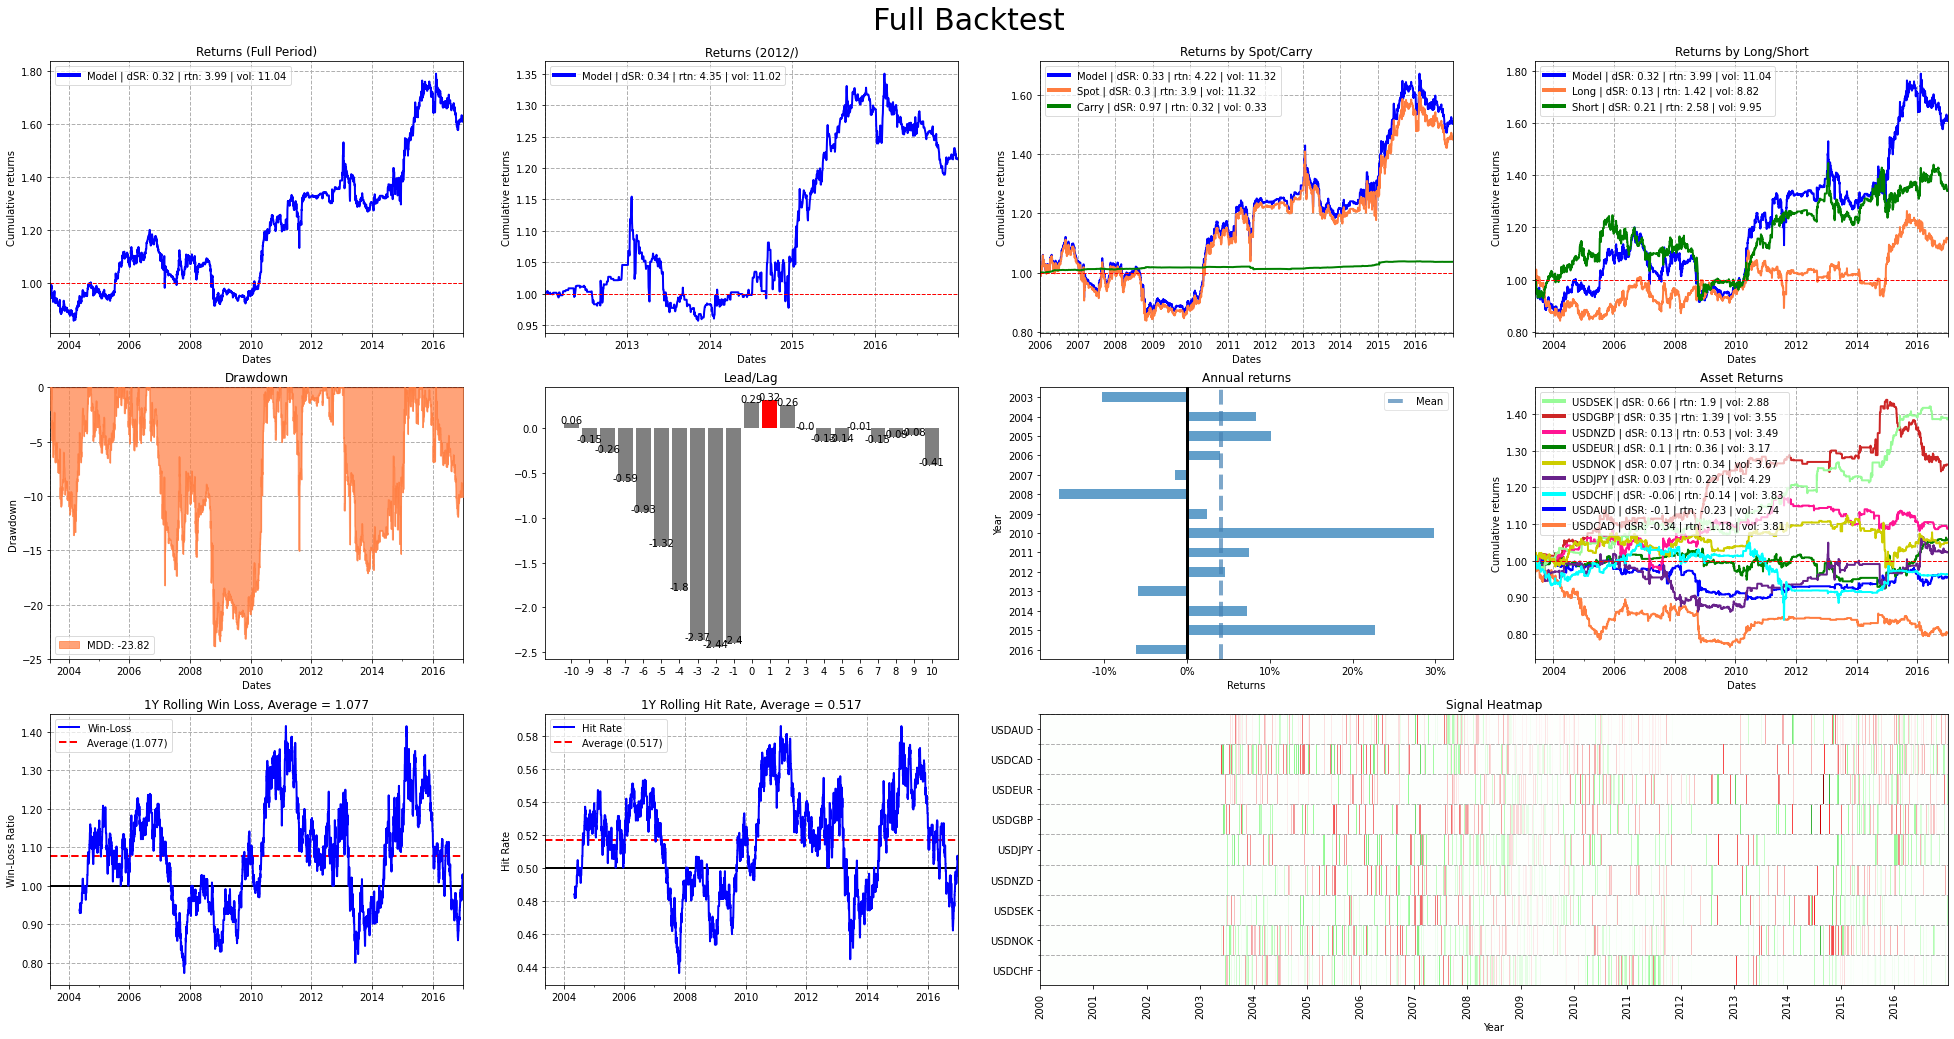

In [16]:
plot_bt(daily_bt)

# Backtest Weekly Rebal

Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


<AxesSubplot:xlabel='Dates', ylabel='Cumulative returns'>

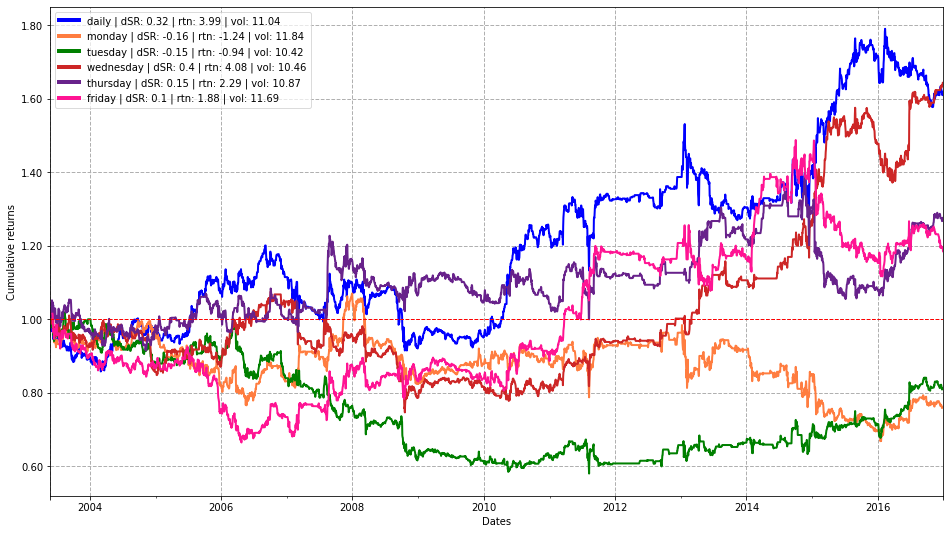

In [17]:
bts = [Backtest(signal = sig, 
             asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings,
             settings_inject = {"rebalance_period":t}) for t in ["monday","tuesday", "wednesday",
                                                                 "thursday", "friday"]]
for bt in bts:
  bt.run()
  
gen_plot_rtn(pd.concat([x.model_rtn.rename(x.rebalance_period) for x in [daily_bt]+bts], axis=1))

In [18]:
pickle.dump(daily_bt, open("../BT/jpm_neer_g10_daily.p", "wb"))
daily_bt = pickle.load(open("../BT/jpm_neer_g10_daily.p", "rb"))

# pickle.dump(weekly_bt, open("../BT/carry_unwinding_all_weekly.p", "wb"))
# weekly_bt = pickle.load(open("../BT/carry_unwinding_all_weekly.p", "rb"))

# Regime Plot

# Sensitivity Analysis